#Loading the Dataset

**Project question: “What patterns exist in contestants’ tap-out narratives? Are there distinct themes of exit?”**

In [75]:
import pandas as pd
import numpy as np
import re
from collections import Counter

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation, TruncatedSVD
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from yellowbrick.cluster import SilhouetteVisualizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
import numpy as np

# These are the files
SURVIVALISTS_PATH = "/content/survivalists.csv"
LOADOUTS_PATH     = "/content/loadouts.csv"
EPISODES_PATH     = "/content/episodes.csv"
SEASONS_PATH      = "/content/seasons.csv"

#1. Data Setup

In [50]:
survivalists = pd.read_csv(SURVIVALISTS_PATH)
print("survivalists shape:", survivalists.shape)
print("columns:\n", survivalists.columns.tolist())

# this is for "tap-out narrative" columns
cands = [c for c in survivalists.columns if re.search(r"tap|reason|exit|quit|med|evac|pull|why|narr", str(c), re.I)]
print("\nLikely tap-out narrative columns:", cands)

# add this one once you pick the right column from the list above:
TAP_COL = "reason_tapped_out"

# this will help set ID + helpful metadata columns if they exist
ID_COL = next((c for c in survivalists.columns if re.search(r"id$", c, re.I)), None)
SEASON_COL = next((c for c in survivalists.columns if re.search(r"season", c, re.I)), None)
DAYS_COL = next((c for c in survivalists.columns if re.search(r"day|days|lasted|duration", c, re.I)), None)

print("\nSuggested columns:")
print("ID_COL:", ID_COL, "| SEASON_COL:", SEASON_COL, "| DAYS_COL:", DAYS_COL)

survivalists shape: (94, 16)
columns:
 ['season', 'name', 'age', 'gender', 'city', 'state', 'country', 'result', 'days_lasted', 'medically_evacuated', 'reason_tapped_out', 'reason_category', 'team', 'day_linked_up', 'profession', 'url']

Likely tap-out narrative columns: ['medically_evacuated', 'reason_tapped_out', 'reason_category']

Suggested columns:
ID_COL: None | SEASON_COL: season | DAYS_COL: days_lasted


#2.Load and Basic Check

Rows total: 94
Missing tap text: 10 (10.6%)
Duplicate narratives (exact text duplicates): 23

--- Sample raw narratives ---
1. Lost fire starter
2. Missed his family
3. Constipation, possible impacted bowel
4. Systolic pressure too low
5. Felt too exhausted and drained to go on
6. Nothing left to give
7. Starvation
8. Had nothing left to accomplish
9. Missed family and felt guilty for having left them behind
10. Bear scare

Word count summary (raw):
count    84.000000
mean      3.750000
std       2.399172
min       1.000000
25%       2.000000
50%       3.000000
75%       4.000000
max      11.000000
Name: wc_raw, dtype: float64


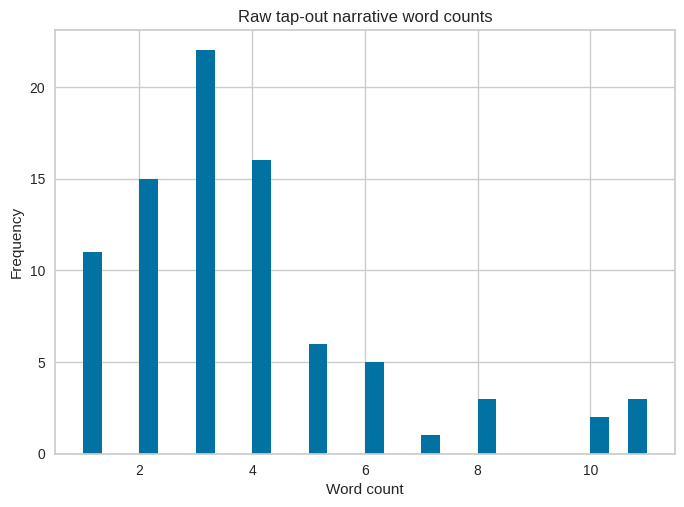

In [49]:
assert TAP_COL is not None, "Set TAP_COL to your tap-out narrative column name first."

df = survivalists.copy()

# this will keep only the rows with some text
df["tap_raw"] = df[TAP_COL].astype(str)
df["tap_raw"] = df["tap_raw"].replace({"nan": np.nan, "None": np.nan, "": np.nan})
print("Rows total:", len(df))
print("Missing tap text:", df["tap_raw"].isna().sum(), f"({df['tap_raw'].isna().mean():.1%})")

# this code duplicates in narrative text
dup_text = df["tap_raw"].dropna().duplicated().sum()
print("Duplicate narratives (exact text duplicates):", dup_text)

# this code shows sample narratives
sample = df["tap_raw"].dropna().sample(min(10, df["tap_raw"].dropna().shape[0]), random_state=7).tolist()
print("\n--- Sample raw narratives ---")
for i, s in enumerate(sample, 1):
    print(f"{i}. {s[:200]}{'...' if len(s)>200 else ''}")

# this is the count
def word_count(s):
    if pd.isna(s): return np.nan
    return len(re.findall(r"\b\w+\b", str(s)))

df["wc_raw"] = df["tap_raw"].apply(word_count)

print("\nWord count summary (raw):")
print(df["wc_raw"].describe())

# Histogram graph
plt.figure()
df["wc_raw"].dropna().hist(bins=30)
plt.title("Raw tap-out narrative word counts")
plt.xlabel("Word count")
plt.ylabel("Frequency")
plt.show()


#3. Text Cleaning Pipeline

Word count summary (cleaned):
count    84.000000
mean      3.071429
std       1.706019
min       1.000000
25%       2.000000
50%       3.000000
75%       4.000000
max       8.000000
Name: wc_clean, dtype: float64

--- Before / After (5 examples) ---

RAW: Had nothing left to accomplish ...
CLN: nothing left accomplish ...

RAW: Lower back injury ...
CLN: lower back injury ...

RAW: Felt too exhausted and drained to go on ...
CLN: felt exhausted drained go ...

RAW: Missed his family ...
CLN: missed his family ...

RAW: Constipation, possible fecal impaction ...
CLN: constipation possible fecal impaction ...


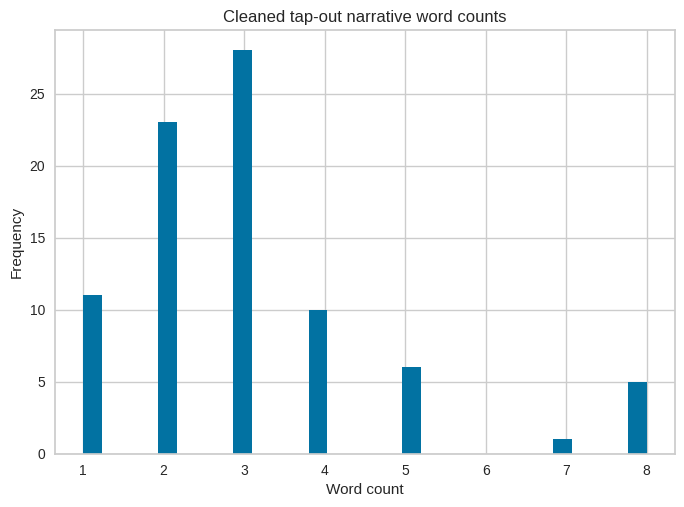

Short narratives (<5 words): 82 (87.2%)


In [73]:
# these are the basic stopwords list
basic_stop = set("""
a an the and or but if then because as while of at by for with about against between into through during before after
above below to from up down in out on off over under again further here there when where why how all any both each
few more most other some such no nor only own same so than too very can will just don should now is are was were be
been being have has had do does did doing would could should may might must
""".split())

# we need to remove 'no'/'nor' so we keep negation meaning
basic_stop.discard("no")
basic_stop.discard("nor")
basic_stop.discard("not") if "not" in basic_stop else None

def clean_text(s):
    if pd.isna(s):
        return np.nan
    s = str(s).lower()
    s = re.sub(r"http\S+|www\.\S+", " ", s)
    s = re.sub(r"[^a-z0-9\s']", " ", s)
    s = re.sub(r"\s+", " ", s).strip()
    tokens = s.split()
    tokens = [t for t in tokens if t not in basic_stop and len(t) > 1]
    return " ".join(tokens)

df["tap_clean"] = df["tap_raw"].apply(clean_text)
df["wc_clean"] = df["tap_clean"].apply(word_count)

print("Word count summary (cleaned):")
print(df["wc_clean"].describe())

# these are before/after examples
ex = df[["tap_raw", "tap_clean"]].dropna().sample(min(5, df["tap_clean"].dropna().shape[0]), random_state=8)
print("\n--- Before / After (5 examples) ---")
for _, row in ex.iterrows():
    print("\nRAW:", str(row["tap_raw"])[:220], "...")
    print("CLN:", str(row["tap_clean"])[:220], "...")

# the hist of cleaned lengths
plt.figure()
df["wc_clean"].dropna().hist(bins=30)
plt.title("Cleaned tap-out narrative word counts")
plt.xlabel("Word count")
plt.ylabel("Frequency")
plt.show()

# these flag very short narratives
SHORT_THRESH = 5
df["is_short"] = df["wc_clean"].fillna(0) < SHORT_THRESH
print("Short narratives (<5 words):", df["is_short"].sum(), f"({df['is_short'].mean():.1%})")

#4.Exploratory Text EDA


Top 20 words:
[('low', 4), ('bmi', 4), ('lost', 4), ('much', 4), ('weight', 4), ('felt', 3), ('he', 2), ('jointly', 2), ('decided', 2), ('cost', 2), ('game', 2), ("wasn't", 2), ('worth', 2), ('it', 2), ('missed', 2), ('family', 2), ('guilty', 2), ('having', 2), ('left', 2), ('them', 2)]

Top 20 bigrams:
[('low bmi', 4), ('bmi lost', 4), ('lost much', 4), ('much weight', 4), ('jointly decided', 2), ('decided cost', 2), ('cost game', 2), ("game wasn't", 2), ("wasn't worth", 2), ('worth it', 2), ('missed family', 2), ('family felt', 2), ('felt guilty', 2), ('guilty having', 2), ('having left', 2), ('left them', 2), ('them behind', 2), ('realized he', 1), ('he actually', 1), ('actually around', 1)]


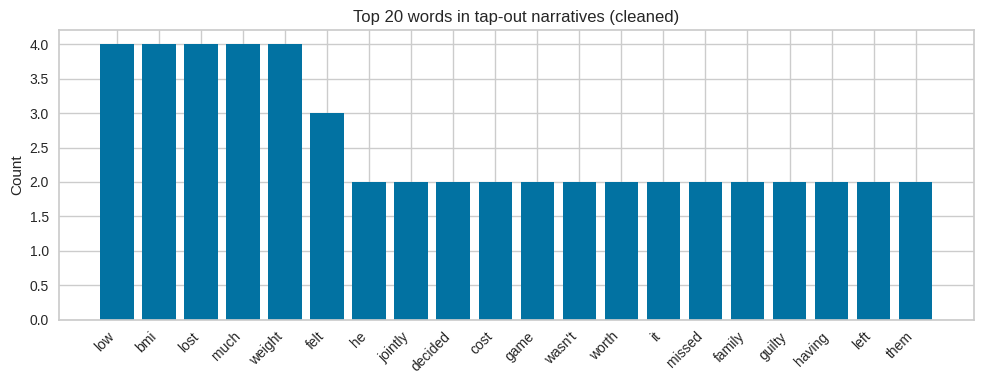

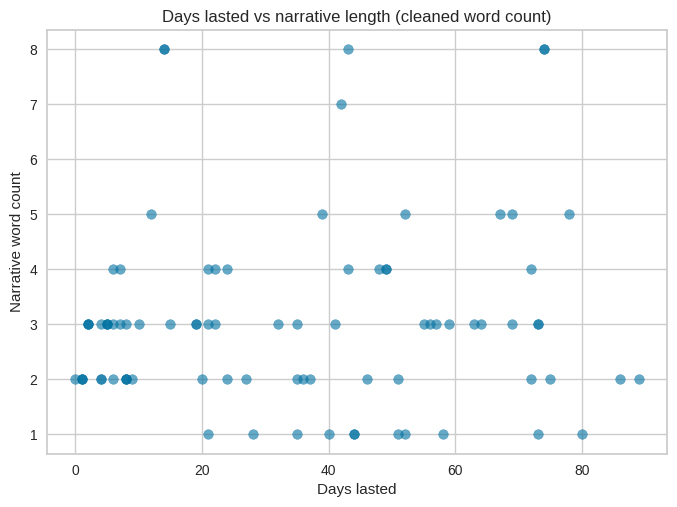

In [72]:
texts = df.loc[~df["is_short"] & df["tap_clean"].notna(), "tap_clean"].tolist()

# the top unigrams
all_words = " ".join(texts).split()
top_words = Counter(all_words).most_common(20)
print("\nTop 20 words:")
print(top_words)

# the top bigrams
bigrams = []
for t in texts:
    toks = t.split()
    bigrams += list(zip(toks[:-1], toks[1:]))
top_bigrams = Counter(bigrams).most_common(20)
print("\nTop 20 bigrams:")
print([(" ".join(bg), c) for bg, c in top_bigrams])

# plot the top 20 words
words, counts = zip(*top_words) if top_words else ([], [])
plt.figure(figsize=(10,4))
plt.bar(words, counts)
plt.xticks(rotation=45, ha="right")
plt.title("Top 20 words in tap-out narratives (cleaned)")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

# the word count vs days lasted
if DAYS_COL is not None and DAYS_COL in df.columns:
    tmp = df[[DAYS_COL, "wc_clean"]].copy()
    tmp = tmp.dropna()
    plt.figure()
    plt.scatter(tmp[DAYS_COL], tmp["wc_clean"], alpha=0.6)
    plt.title("Days lasted vs narrative length (cleaned word count)")
    plt.xlabel("Days lasted")
    plt.ylabel("Narrative word count")
    plt.show()
else:
    print("\nNo days-lasted column detected. If you have one, set DAYS_COL manually.")

#5. Method 1 — Topic Modeling

In [68]:
if "tap_clean" not in df.columns or "is_short" not in df.columns:
    print("Running text cleaning pipeline as columns were not found.")
    # they could be re-define necessary functions/variables if the cleaning cell wasn't run
    basic_stop = set("""
a an the and or but if then because as while of at by for with about against between into through during before after
above below to from up down in out on off over under again further here there when where why how all any both each
few more most other some such no nor only own same so than too very can will just don should now is are was were be
been being have has had do does did doing would could should may might must
""".split())
    basic_stop.discard("no")
    basic_stop.discard("nor")
    basic_stop.discard("not") if "not" in basic_stop else None

    def word_count(s):
        if pd.isna(s): return np.nan
        return len(re.findall(r"\b\w+\b", str(s)))

    def clean_text(s):
        if pd.isna(s):
            return np.nan
        s = str(s).lower()
        s = re.sub(r"http\S+|www\.\S+", " ", s)
        s = re.sub(r"[^a-z0-9\s']", " ", s)
        s = re.sub(r"\s+", " ", s).strip()
        tokens = s.split()
        tokens = [t for t in tokens if t not in basic_stop and len(t) > 1]
        return " ".join(tokens)

    df["tap_clean"] = df["tap_raw"].apply(clean_text)
    df["wc_clean"] = df["tap_clean"].apply(word_count)
    SHORT_THRESH = 5
    df["is_short"] = df["wc_clean"].fillna(0) < SHORT_THRESH


docs = df.loc[~df["is_short"] & df["tap_clean"].notna(), "tap_clean"].tolist()

# the TF-IDF works well for NMF
tfidf = TfidfVectorizer(max_df=0.9, min_df=2, ngram_range=(1,2))
X = tfidf.fit_transform(docs)
terms = np.array(tfidf.get_feature_names_out())

def print_nmf_topics(model, terms, top_n=12):
    for i, comp in enumerate(model.components_):
        top_idx = np.argsort(comp)[::-1][:top_n]
        print(f"\nTopic {i}: " + ", ".join(terms[top_idx]))

for k in [4, 6, 8, 10]:
    nmf = NMF(n_components=k, random_state=42, init="nndsvd", max_iter=400)
    W = nmf.fit_transform(X)
    print("\n" + "="*60)
    print(f"NMF with K={k}")
    print_nmf_topics(nmf, terms, top_n=12)

Running text cleaning pipeline as columns were not found.

NMF with K=4

Topic 0: weight, lost much, low bmi, low, much, much weight, bmi, lost, bmi lost, them behind, worth it, wasn

Topic 1: them behind, left, left them, missed, missed family, them, felt guilty, behind, family, family felt, guilty, having left

Topic 2: worth it, worth, wasn worth, wasn, it, jointly, cost game, decided, jointly decided, cost, decided cost, game wasn

Topic 3: he, felt, weight, wasn worth, worth it, worth, them behind, wasn, much, them, missed, low bmi

NMF with K=6

Topic 0: weight, lost much, low bmi, low, much, much weight, bmi, lost, bmi lost, them behind, worth it, wasn

Topic 1: them behind, left, left them, missed, missed family, them, felt guilty, behind, family, family felt, guilty, having left

Topic 2: worth it, worth, wasn worth, wasn, it, jointly, cost game, decided, jointly decided, cost, decided cost, game wasn

Topic 3: he, felt, weight, wasn worth, worth it, worth, them behind, wasn, 

In [58]:
FINAL_K = 6

nmf = NMF(n_components=FINAL_K, random_state=42, init="nndsvd", max_iter=400)
W = nmf.fit_transform(X)
topic_assign = W.argmax(axis=1)

# these show top words
print("\nFINAL NMF TOPICS")
print_nmf_topics(nmf, terms, top_n=15)

# the representative docs: highest topic weight per topic
idxs = np.arange(len(docs))
for t in range(FINAL_K):
    t_idxs = idxs[topic_assign == t]
    if len(t_idxs) == 0:
        continue
    # this ranks by strength
    strengths = W[t_idxs, t]
    top_docs = t_idxs[np.argsort(strengths)[::-1][:3]]
    print("\n" + "-"*60)
    print(f"Topic {t} representative narratives:")
    for j in top_docs:
        print(" •", docs[j][:250], "..." if len(docs[j])>250 else "")



FINAL NMF TOPICS

Topic 0: weight, lost much, low bmi, low, much, much weight, bmi, lost, bmi lost, them behind, worth it, wasn, wasn worth, worth, missed

Topic 1: them behind, left, left them, missed, missed family, them, felt guilty, behind, family, family felt, guilty, having left, guilty having, having, felt

Topic 2: worth it, worth, wasn worth, wasn, it, jointly, cost game, decided, jointly decided, cost, decided cost, game wasn, game, weight, them behind

Topic 3: he, felt, weight, wasn worth, worth it, worth, them behind, wasn, much, them, missed, low bmi, low, much weight, lost much

Topic 4: felt, worth it, weight, wasn worth, wasn, worth, them behind, them, much, much weight, missed, low bmi, low, missed family, lost

Topic 5: worth it, worth, weight, wasn worth, wasn, them behind, them, much weight, much, missed family, missed, low bmi, low, lost much, lost

------------------------------------------------------------
Topic 0 representative narratives:
 • low bmi lost muc

In [85]:
cv = CountVectorizer(max_df=0.9, min_df=2, ngram_range=(1, 2))
Xc = cv.fit_transform(docs)
terms_c = np.array(cv.get_feature_names_out())

for k in [6, 8]:
    lda = LatentDirichletAllocation(
        n_components=k,
        random_state=42,
        learning_method="batch"
    )
    lda.fit(Xc)

    print("\n" + "=" * 60)
    print(f"LDA with K={k}")

    for i, comp in enumerate(lda.components_):
        top_idx = np.argsort(comp)[::-1][:12]
        print(f"Topic {i}: " + ", ".join(terms_c[top_idx]))



LDA with K=6
Topic 0: worth it, worth, wasn worth, wasn, it, jointly, cost game, decided, jointly decided, cost, decided cost, game wasn
Topic 1: he, felt, much weight, low, weight, lost much, bmi, bmi lost, lost, much, low bmi, worth it
Topic 2: he, felt, much weight, low, weight, lost much, bmi, bmi lost, lost, much, low bmi, worth it
Topic 3: he, felt, much weight, low, weight, lost much, bmi, bmi lost, lost, much, low bmi, worth it
Topic 4: felt, them behind, missed family, missed, them, left, family, behind, felt guilty, family felt, guilty having, having left
Topic 5: weight, lost much, low bmi, low, much, much weight, bmi, lost, bmi lost, he, felt, worth it

LDA with K=8
Topic 0: worth it, worth, wasn worth, wasn, it, jointly, cost game, decided, jointly decided, cost, decided cost, game wasn
Topic 1: he, felt, much weight, low, weight, lost much, bmi, bmi lost, lost, much, low bmi, worth it
Topic 2: he, felt, much weight, low, weight, lost much, bmi, bmi lost, lost, much, low 

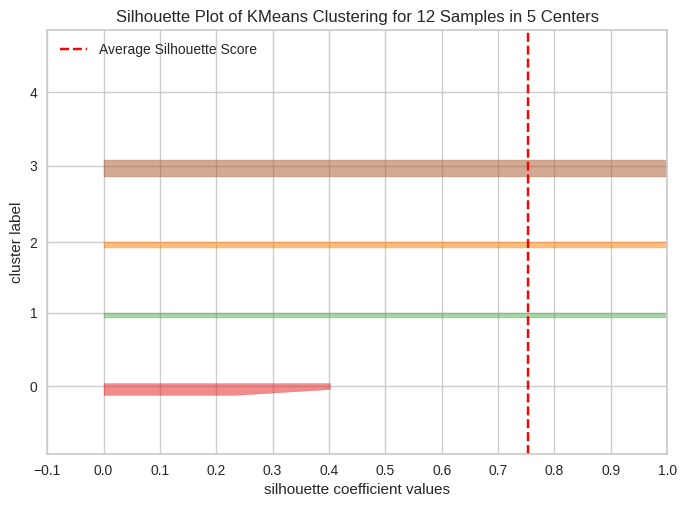

<Axes: title={'center': 'Silhouette Plot of KMeans Clustering for 12 Samples in 5 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [77]:
kmeans_model = KMeans(n_clusters=FINAL_K_CLUST, random_state=42, n_init=10)
visualizer = SilhouetteVisualizer(kmeans_model, timings=False)

visualizer.fit(E_scaled)
visualizer.show()

#6. Method 2 — Embeddings and Clustering

Silhouette by K: {4: np.float64(0.7779395033202698), 5: np.float64(0.8820227374515817), 6: np.float64(0.8333333333333334), 7: np.float64(0.8333333333333334), 8: np.float64(0.8333333333333334), 10: np.float64(0.8333333333333334)}


/usr/local/lib/python3.12/dist-packages/sklearn/base.py:1389: ConvergenceWarning: Number of distinct clusters (6) found smaller than n_clusters (7). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
/usr/local/lib/python3.12/dist-packages/sklearn/base.py:1389: ConvergenceWarning: Number of distinct clusters (6) found smaller than n_clusters (8). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
/usr/local/lib/python3.12/dist-packages/sklearn/base.py:1389: ConvergenceWarning: Number of distinct clusters (6) found smaller than n_clusters (10). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)


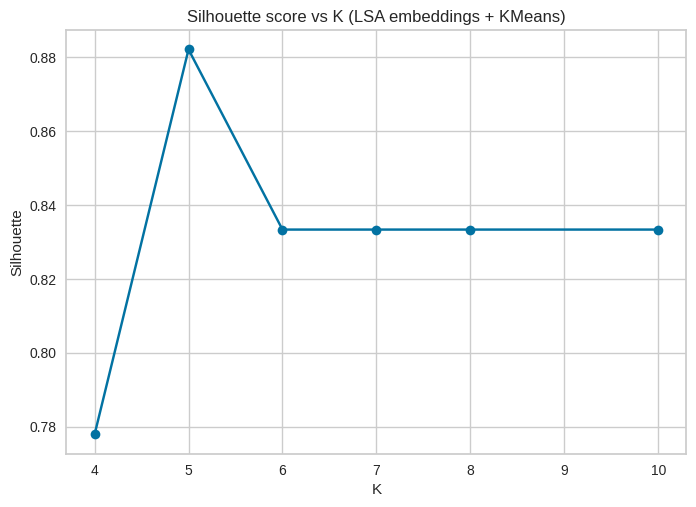

In [69]:
if "tap_clean" not in df.columns or "is_short" not in df.columns:
    print("Running text cleaning pipeline as columns were not found.")

    basic_stop = set("""
a an the and or but if then because as while of at by for with about against between into through during before after
above below to from up down in out on off over under again further here there when where why how all any both each
few more most other some such no nor only own same so than too very can will just don should now is are was were be
been being have has had do does did doing would could should may might must
""".split())
    basic_stop.discard("no")
    basic_stop.discard("nor")
    basic_stop.discard("not") if "not" in basic_stop else None

    def word_count(s):
        if pd.isna(s): return np.nan
        return len(re.findall(r"\b\w+\b", str(s)))

    def clean_text(s):
        if pd.isna(s):
            return np.nan
        s = str(s).lower()
        s = re.sub(r"http\S+|www\.\S+", " ", s)
        s = re.sub(r"[^a-z0-9\s']", " ", s)
        s = re.sub(r"\s+", " ", s).strip()
        tokens = s.split()
        tokens = [t for t in tokens if t not in basic_stop and len(t) > 1]
        return " ".join(tokens)

    df["tap_clean"] = df["tap_raw"].apply(clean_text)
    df["wc_clean"] = df["tap_clean"].apply(word_count)
    SHORT_THRESH = 5
    df["is_short"] = df["wc_clean"].fillna(0) < SHORT_THRESH

docs = df.loc[~df["is_short"] & df["tap_clean"].notna(), "tap_clean"].tolist()

tfidf2 = TfidfVectorizer(max_df=0.9, min_df=2, ngram_range=(1,2))
X2 = tfidf2.fit_transform(docs)

# these are the LSA / SVD embeddings
svd_dims = 100
svd = TruncatedSVD(n_components=min(svd_dims, X2.shape[1]-1), random_state=42)
E = svd.fit_transform(X2)

from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
E_scaled = sc.fit_transform(E)

# for trying different K, track silhouette
Ks = [4, 5, 6, 7, 8, 10]
sil = {}
for k in Ks:
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = km.fit_predict(E)
    if len(set(labels)) > 1:
        sil[k] = silhouette_score(E, labels)
    else:
        sil[k] = np.nan

print("Silhouette by K:", sil)

plt.figure()
plt.plot(list(sil.keys()), list(sil.values()), marker="o")
plt.title("Silhouette score vs K (LSA embeddings + KMeans)")
plt.xlabel("K")
plt.ylabel("Silhouette")
plt.show()

Auto-selected FINAL_K_CLUST (max silhouette): 5

Cluster sizes:
0    2
1    4
2    2
3    2
4    2
Name: count, dtype: int64


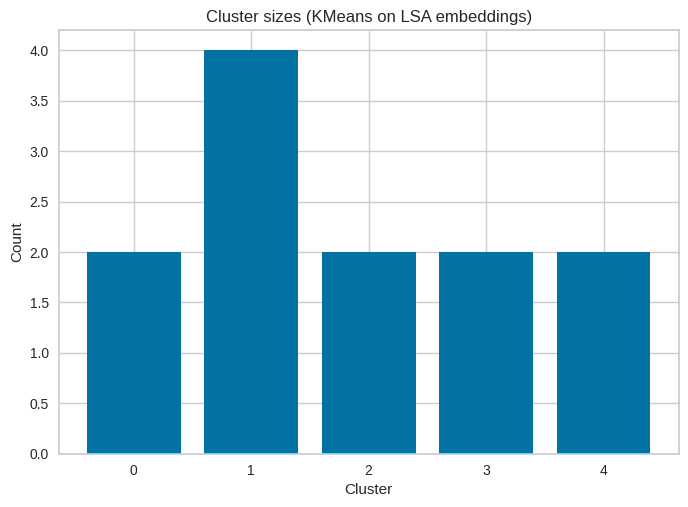


------------------------------------------------------------
Cluster 0 representative narratives:
 • jointly decided cost game wasn't worth it 
 • jointly decided cost game wasn't worth it 

------------------------------------------------------------
Cluster 1 representative narratives:
 • low bmi lost much weight 
 • low bmi lost much weight 
 • low bmi lost much weight 
 • low bmi lost much weight parastic infection 

------------------------------------------------------------
Cluster 2 representative narratives:
 • realized he actually around his mother's cancer 
 • felt content what he done 

------------------------------------------------------------
Cluster 3 representative narratives:
 • missed family felt guilty having left them behind 
 • missed family felt guilty having left them behind 

------------------------------------------------------------
Cluster 4 representative narratives:
 • broken teeth molars jaw pain 
 • torn meniscus partially torn mcl 


In [61]:
FINAL_K_CLUST = max(sil, key=lambda k: sil[k] if not np.isnan(sil[k]) else -1)
print("Auto-selected FINAL_K_CLUST (max silhouette):", FINAL_K_CLUST)

km = KMeans(n_clusters=FINAL_K_CLUST, random_state=42, n_init=10)
cluster_labels = km.fit_predict(E)

# the cluster sizes
sizes = pd.Series(cluster_labels).value_counts().sort_index()
print("\nCluster sizes:")
print(sizes)

plt.figure()
plt.bar(sizes.index.astype(str), sizes.values)
plt.title("Cluster sizes (KMeans on LSA embeddings)")
plt.xlabel("Cluster")
plt.ylabel("Count")
plt.show()

# the representative docs per cluster
centroids = km.cluster_centers_
for c in range(FINAL_K_CLUST):
    idxs = np.where(cluster_labels == c)[0]
    if len(idxs) == 0:
        continue
    dists = np.linalg.norm(E[idxs] - centroids[c], axis=1)
    rep = idxs[np.argsort(dists)[:5]]
    print("\n" + "-"*60)
    print(f"Cluster {c} representative narratives:")
    for j in rep:
        print(" •", docs[j][:250], "..." if len(docs[j])>250 else "")


#7)Compare Methods Theme Mapping Table

In [63]:
# this will create a dataframe with docs and assignments
out = pd.DataFrame({
    "tap_clean": docs,
    "topic_nmf": topic_assign,
    "cluster": cluster_labels
})

out.head()


,tap_clean,topic_nmf,cluster
0,realized he actually around his mother's cancer,3,2
1,felt content what he done,4,2
2,broken teeth molars jaw pain,0,4
3,jointly decided cost game wasn't worth it,2,0
4,jointly decided cost game wasn't worth it,2,0


#8) Findings: Prevalence and Days Lasted by Theme

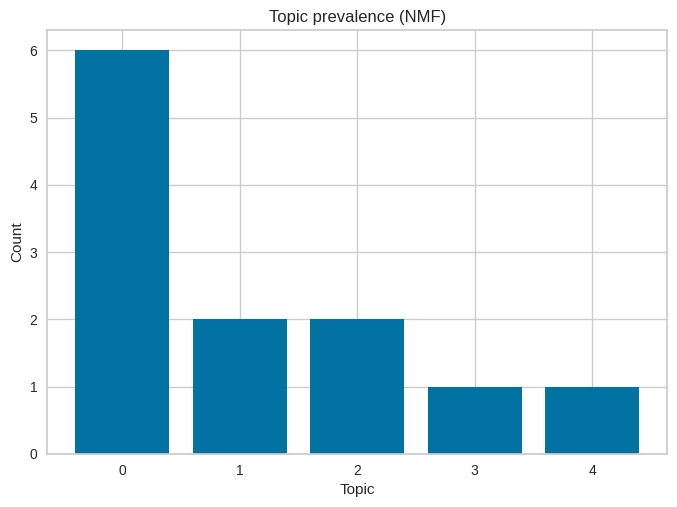

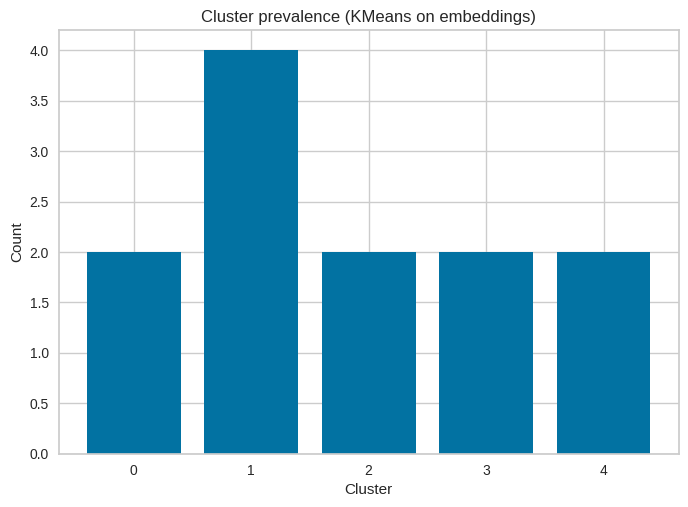

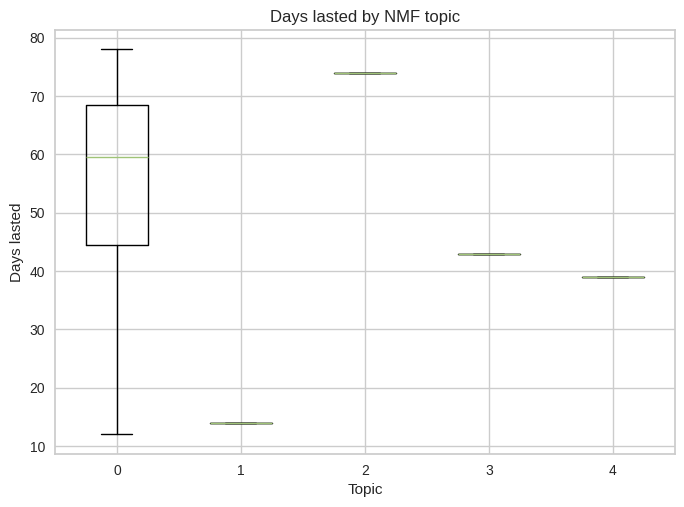

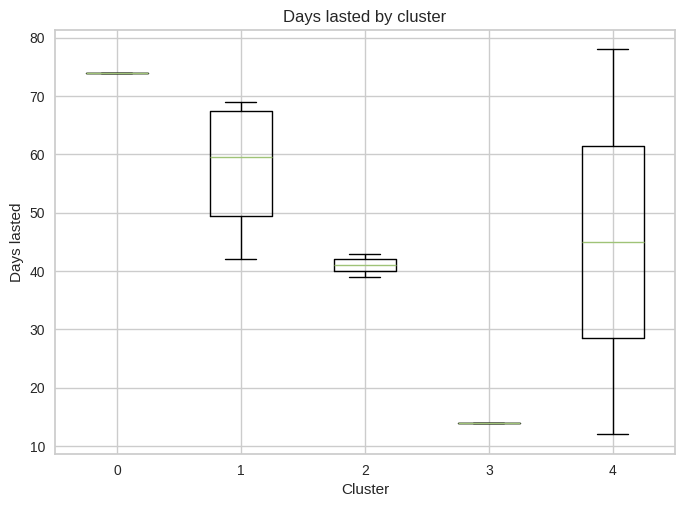

In [71]:
if "tap_clean" not in df.columns or "is_short" not in df.columns:
    print("Running text cleaning pipeline as columns were not found.")

    basic_stop = set("""
a an the and or but if then because as while of at by for with about against between into through during before after
above below to from up down in out on off over under again further here there when where why how all any both each
few more most other some such no nor only own same so than too very can will just don should now is are was were be
been being have has had do does did doing would could should may might must
""".split())
    basic_stop.discard("no")
    basic_stop.discard("nor")
    basic_stop.discard("not") if "not" in basic_stop else None

    def word_count(s):
        if pd.isna(s): return np.nan
        return len(re.findall(r"\b\w+\b", str(s)))

    def clean_text(s):
        if pd.isna(s):
            return np.nan
        s = str(s).lower()
        s = re.sub(r"http\S+|www\.\S+", " ", s)
        s = re.sub(r"[^a-z0-9\s']", " ", s)
        s = re.sub(r"\s+", " ", s).strip()
        tokens = s.split()
        tokens = [t for t in tokens if t not in basic_stop and len(t) > 1]
        return " ".join(tokens)

    df["tap_clean"] = df["tap_raw"].apply(clean_text)
    df["wc_clean"] = df["tap_clean"].apply(word_count)
    SHORT_THRESH = 5
    df["is_short"] = df["wc_clean"].fillna(0) < SHORT_THRESH


# this will attach assignments back to df rows used in modeling
mask = (~df["is_short"]) & (df["tap_clean"].notna())
df_model = df.loc[mask].copy()
df_model["topic_nmf"] = topic_assign
df_model["cluster"] = cluster_labels

# the theme prevalence plots
topic_counts = df_model["topic_nmf"].value_counts().sort_index()
plt.figure()
plt.bar(topic_counts.index.astype(str), topic_counts.values)
plt.title("Topic prevalence (NMF)")
plt.xlabel("Topic")
plt.ylabel("Count")
plt.show()

cluster_counts = df_model["cluster"].value_counts().sort_index()
plt.figure()
plt.bar(cluster_counts.index.astype(str), cluster_counts.values)
plt.title("Cluster prevalence (KMeans on embeddings)")
plt.xlabel("Cluster")
plt.ylabel("Count")
plt.show()

# these are the days lasted by topic/cluster
if DAYS_COL is not None and DAYS_COL in df_model.columns:
    # By topic
    groups = [df_model.loc[df_model["topic_nmf"]==t, DAYS_COL].dropna().values for t in sorted(df_model["topic_nmf"].unique())]
    plt.figure()
    plt.boxplot(groups, tick_labels=[str(t) for t in sorted(df_model["topic_nmf"].unique())])
    plt.title("Days lasted by NMF topic")
    plt.xlabel("Topic")
    plt.ylabel("Days lasted")
    plt.show()

    # sort by cluster
    groups = [df_model.loc[df_model["cluster"]==c, DAYS_COL].dropna().values for c in sorted(df_model["cluster"].unique())]
    plt.figure()
    plt.boxplot(groups, tick_labels=[str(c) for c in sorted(df_model["cluster"].unique())])
    plt.title("Days lasted by cluster")
    plt.xlabel("Cluster")
    plt.ylabel("Days lasted")
    plt.show()
else:
    print("No days-lasted column available/detected; set DAYS_COL manually if you have it.")